In [122]:
import pandas as pd
import numpy as np 
from itertools import permutations, combinations
import math
import random
import ete3
from ete3 import Tree
import phylogeny
from phylogeny import DistanceMatrix


## Additive Matrix Generation

In [123]:
#generate a tree to obtain a additive distance matrix 

class Vertex:
    def __init__(self, node):
        self.id = node
        self.adjacent = {}

    def __str__(self):
        return str([x.id for x in self.adjacent])

    def add_neighbor(self, neighbor, weight=0):
        self.adjacent[neighbor] = weight

    def get_connections(self):
        return self.adjacent.keys()  

    def get_id(self):
        return self.id

    def get_weight(self, neighbor):
        return self.adjacent[neighbor]

class MatrixTree:
    def __init__(self):
        self.vert_dict = {}
        self.num_vertices = 0

    def __iter__(self):
        return iter(self.vert_dict.values())

    def add_vertex(self, node):
        self.num_vertices = self.num_vertices + 1
        new_vertex = Vertex(node)
        self.vert_dict[node] = new_vertex
        return new_vertex

    def get_vertex(self, n):
        if n in self.vert_dict:
            return self.vert_dict[n]
        else:
            return None

    def add_edge(self, frm, to, cost = 0):
        if frm not in self.vert_dict:
            self.add_vertex(frm)
        if to not in self.vert_dict:
            self.add_vertex(to)

        self.vert_dict[frm].add_neighbor(self.vert_dict[to], cost)
        self.vert_dict[to].add_neighbor(self.vert_dict[frm], cost)

    def get_vertices(self):
        return self.vert_dict.keys()

In [124]:
def get_tree():   
    output = (np.array([random.randrange(1, 5) for _ in range(0, 5)]))

    #generate n+1 random edge weights where n = # of nodes + a weight for a connecting branch

    t = MatrixTree()

    t.add_vertex('a')
    t.add_vertex('b')
    t.add_vertex('c')
    t.add_vertex('d')

    t.add_edge('a', 'b', output[0] + output[1])   #dist between a to b
    t.add_edge('a', 'c', output[0] + output[4] + output[2]) #distance between a, connecting limb, c
    t.add_edge('a', 'd', output[0] + output[4] + output[3]) 
    t.add_edge('b', 'c', output[1] + output[4] + output[2])
    t.add_edge('b', 'd', output[1] + output[4] + output[3])
    t.add_edge('c', 'd', output[2] + output[3])
    return t

In [125]:
# get dict of dicts for each node, neighbors, distance to neighbors 
def get_matrix(tree):
    D = {}
    for v in tree:
        vid = v.get_id()
        D[vid] = {vid : 0} # assign distance from itself to 0
        for w in v.get_connections():
            wid = w.get_id()
            D[vid][wid] = int(v.get_weight(w))
    return D

In [126]:
mat= pd.DataFrame.from_dict(get_matrix(get_tree())) #convert to 2d matrix
#visualize as n x n distance matrix         
mat

,a,b,c,d
a,0,4,11,9
b,4,0,9,7
c,11,9,0,6
d,9,7,6,0


## Additive matrix check

In [127]:
mat = get_matrix(get_tree())
mat = pd.DataFrame.from_dict(mat)
d = DistanceMatrix(mat, names=('A', 'B', 'C', 'D'))
d.is_additive()

True

## Neigbor join

In [128]:
import copy
def NJ(dm):
    edge_list = []
    clusters = []
    for cluster in list(dm):
        clusters.append(cluster)
    cluster2idx = { name : idx for idx, name in enumerate(clusters) }
    idx2cluster = copy.deepcopy(clusters)
    m = copy.deepcopy(dm).to_dict()
    result = ""
    M, N = dm.shape
    new_cluster_idx = M+1 
    while len(clusters) > 1:
        idx1 = None
        idx2 = None
        ui = 0
        uj = 0
        Sd = 100000
        for i in clusters:
            for j in clusters:
                if i != j:
                    ui_t = sum(m[i][k] for k in clusters)
                    uj_t = sum(m[j][k] for k in clusters)
                    curr = (M - 2) * m[i][j] - ui_t - uj_t
                    if Sd > curr:
                        Sd = curr
                        idx1 = cluster2idx[i]
                        idx2 = cluster2idx[j]
                        ui = ui_t
                        uj = uj_t

        Dij = m[idx2cluster[idx1]][idx2cluster[idx2]]
        new_cluster = "(" + idx2cluster[idx1] +"." + idx2cluster[idx2] + ")"
        result = new_cluster
        m[new_cluster] = {}
        new_cluster_idx += 1

        if M - 2 != 0:            
            m[idx2cluster[idx1]][new_cluster] = (float(m[idx2cluster[idx1]][idx2cluster[idx2]]) + (1/(M-2)) * (ui - uj))/2
            m[idx2cluster[idx2]][new_cluster] = (float(m[idx2cluster[idx1]][idx2cluster[idx2]]) + (1/(M-2)) * (uj - ui))/2
            edge_list.append((new_cluster, idx2cluster[idx1], m[idx2cluster[idx1]][new_cluster]))
            edge_list.append((new_cluster, idx2cluster[idx2], m[idx2cluster[idx2]][new_cluster]))
        else:
            edge_list.append((idx2cluster[idx1], idx2cluster[idx2], m[idx2cluster[idx1]][idx2cluster[idx2]]))

        clusters.remove(idx2cluster[idx1])
        clusters.remove(idx2cluster[idx2])

        m[new_cluster][new_cluster] = 0
        for c in clusters:
            m[c][new_cluster] = (m[c][idx2cluster[idx1]] + m[c][idx2cluster[idx2]] - Dij)/2
            m[new_cluster][c] = m[c][new_cluster]
            for k in list(m[c].keys()):
                if k == idx2cluster[idx1] or k == idx2cluster[idx2]:
                    del m[c][k]

        del cluster2idx[idx2cluster[idx1]]
        del cluster2idx[idx2cluster[idx2]]
        if idx2cluster[idx1] in m: del m[idx2cluster[idx1]]
        if idx2cluster[idx2] in m: del m[idx2cluster[idx2]]

        clusters.append(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        M -= 1
        N -= 1
    return result, edge_list

## Degenerate Triples Algorithm

In [129]:
def check_and_find_degenerate(D, cols):
    triplets = permutations(D.index,3)
    for triplet in triplets:
        i,j,k = triplet
        if D[i][j] + D[j][k] == D[i][k]:
            return i,j,k, True
        
    return -1,-1,-1, False
    
def compute_trimming_param(D,cols):
    triplets = permutations(D.index,3)
    min_delta = float('inf')
    best_i,best_j,best_k = -1,-1,-1
    for triplet in triplets:
        i,j,k = triplet
        delta = (D[i][j] + D[j][k] - D[i][k])/2
        if delta > 0 and delta < min_delta:
            min_delta = delta
            best_i,best_j,best_k = i,j,k
            
    return min_delta, best_i,best_j,best_k

def Trim(D, delta):
    D = D - (2*delta)
    for i in D.index:
        D[i][i] = 0
    return D

def additive_phylogeny(D, v, cols):
    if D.shape == (2,2):
        T = {D.index[0] : {D.index[1]: D[D.index[0]][D.index[1]]}, 
             D.index[1] : {D.index[0]: D[D.index[1]][D.index[0]]}}
        return T
    i,j,k,flag = check_and_find_degenerate(D, cols)
    if not flag:
        delta,best_i,best_j,best_k = compute_trimming_param(D, cols)
        i,j,k = best_i,best_j,best_k
        D = Trim(D, delta)
    else:
        delta = 0
    #print(flag)
    x = D[i][j]
    D = D.drop([j])
    D = D.drop(j, axis=1)
    T = additive_phylogeny(D, v+1, cols)
    T[v] = {i:x}
    T[i] = {v:x}
    #print(T)
    if v + 1 in T:
        del T[v+1][i]
        
        leftover = 0
        curr_v = v
        while k not in T[curr_v].keys():
            curr_v += 1
        final_v = curr_v
        curr_v = v
        leftover = 0
        while curr_v+2 < final_v:
            leftover += T[curr_v+1][curr_v+2]
            curr_v += 1
        leftover += T[final_v][k]
        T[v][v+1] = D[i][k]-x-leftover
        T[v+1][v] = D[i][k]-x-leftover
    else:
        T[v][k] = D[i][k]-x
        T[k] = {v:D[i][k]-x}
    
    T[v][j] = 0
    T[j] = {v:0}
    for l in T:
        if l in D.index and j in D.index and T[l][v] != D[l][j]:
            print('Matrix not additive')
            return
    for v in T:
        for l in cols:
            if l in T[v] and type(v) == int:
                T[l][v] =  T[l][v] + (delta)
                T[v][l] =  T[v][l] + (delta)
            
    return T

def degen_triples(D):
    cols = ''
    for i in D.index:
        cols += i
    
    return additive_phylogeny(D, 0, cols)

def create_edge_list(T):
    edge_list = []
    for v1 in T:
        for v2 in T[v1]:
            if type(v1) == int and (v1,v2,T[v1][v2]) not in edge_list and (v2,v1,T[v2][v1]) not in edge_list:
                edge_list.append((v1,v2, T[v1][v2]))
    return edge_list


In [130]:
def check_matrix(newick_string, original_matrix):
    import pandas as pd
    import itertools
    from Bio import Phylo
    import io
    
    treedata = newick_string
    handle = io.StringIO(treedata)
    t = Phylo.read(handle, "newick")
    d = {}
    for x, y in itertools.combinations(t.get_terminals(), 2):
        v = t.distance(x, y)
        d[x.name] = d.get(x.name, {})
        d[x.name][y.name] = v
        d[y.name] = d.get(y.name, {})
        d[y.name][x.name] = v
    for x in t.get_terminals():
        d[x.name][x.name] = 0

    m = pd.DataFrame(d)
    return m == original_matrix

## Some hard-coded Distance Matrix Cases

In [131]:
not_additive_tree = {'A': {'A': 0, 'B': 6, 'C': 6, 'D': 8},
                    'B': {'A': 6, 'B': 0, 'C': 8, 'D': 2},
                    'C': {'A': 6, 'B': 8, 'C': 0, 'D': 10},
                    'D': {'A': 8, 'B': 2, 'C': 10, 'D': 0}}
not_additive_matrix = pd.DataFrame.from_dict(not_additive_tree)

additive_tree1 = {'A': {'A': 0, 'B': 4, 'C': 10, 'D': 9},
                    'B': {'A': 4, 'B': 0, 'C': 8, 'D': 7},
                    'C': {'A': 10, 'B': 8, 'C': 0, 'D': 9},
                    'D': {'A': 9, 'B': 7, 'C': 9, 'D': 0}}
additive_matrix1 = pd.DataFrame.from_dict(additive_tree1)

big_tree = {'A': {'A': 0, 'B': 3, 'C': 7, 'D': 9, 'E': 2},
        'B': {'A': 3, 'B': 0, 'C': 6, 'D': 8, 'E': 1},
        'C': {'A': 7, 'B': 6, 'C': 0, 'D': 6, 'E': 5},
        'D': {'A': 9, 'B': 8, 'C': 6, 'D': 0, 'E': 7},
        'E': {'A': 2, 'B': 1, 'C': 5, 'D': 7, 'E': 0}}
big_dm = pd.DataFrame.from_dict(big_tree)

big_tree2 = {'A': {'A': 0, 'B': 10, 'C': 17, 'D': 16, 'E': 16},
             'B': {'A': 10, 'B': 0, 'C': 15, 'D': 14, 'E': 14},
             'C': {'A': 17, 'B': 15, 'C': 0, 'D': 9, 'E': 15},
             'D': {'A': 16, 'B': 14, 'C': 9, 'D': 0, 'E': 14},
             'E': {'A': 16, 'B': 14, 'C': 15, 'D': 14, 'E': 0}}

big_dm2 = pd.DataFrame.from_dict(big_tree2)

## Example of a case, testing the graph, and comparing the resulting trees with the Robinson-foulds metric

In [132]:
mat = additive_matrix1
T = degen_triples(mat)
print(mat)
ete_dt_tree = Tree.from_parent_child_table(create_edge_list(T))
print(ete_dt_tree)
print(ete_dt_tree.write())
nj_result, nj_list = NJ(mat)
ete_nj_tree = Tree.from_parent_child_table(nj_list)
print(ete_nj_tree)
print(ete_nj_tree.write())
print(check_matrix(ete_dt_tree.write(), mat))
print(check_matrix(ete_nj_tree.write(), mat))
print('distance: ' + str(ete_dt_tree.robinson_foulds(ete_nj_tree,unrooted_trees=True)[0]))

    A  B   C  D
A   0  4  10  9
B   4  0   8  7
C  10  8   0  9
D   9  7   9  0

   /-C
  |
--|--D
  |
  |   /-A
   \-|
      \-B
(C:5,D:4,(A:3,B:1)1:2);

   /-A
  |
--|--B
  |
  |   /-C
   \-|
      \-D
(A:3,B:1,(C:5,D:4)1:2);
      A     B     C     D
A  True  True  True  True
B  True  True  True  True
C  True  True  True  True
D  True  True  True  True
      A     B     C     D
A  True  True  True  True
B  True  True  True  True
C  True  True  True  True
D  True  True  True  True
distance: 0


In [133]:
mat = not_additive_matrix
T = degen_triples(mat)
print(mat)
ete_dt_tree = Tree.from_parent_child_table(create_edge_list(T))
print(ete_dt_tree)
print(ete_dt_tree.write())
nj_result, nj_list = NJ(mat)
ete_nj_tree = Tree.from_parent_child_table(nj_list)
print(ete_nj_tree)
print(ete_nj_tree.write())
print(check_matrix(ete_dt_tree.write(), mat))
print(check_matrix(ete_nj_tree.write(), mat))
print('distance: ' + str(ete_dt_tree.robinson_foulds(ete_nj_tree,unrooted_trees=True)[0]))

   A  B   C   D
A  0  6   6   8
B  6  0   8   2
C  6  8   0  10
D  8  2  10   0

   /-C
  |
--|--D
  |
  |   /-A
   \-|
      \-B
(C:4,D:6,(A:6,B:0)1:-4);

   /-A
  |
--|--C
  |
  |   /-B
   \-|
      \-D
(A:2,C:4,(B:0,D:2)1:4);
      A      B      C     D
A  True   True   True  True
B  True   True  False  True
C  True  False   True  True
D  True   True   True  True
      A     B     C     D
A  True  True  True  True
B  True  True  True  True
C  True  True  True  True
D  True  True  True  True
distance: 2


## Runtime

In [134]:
import timeit
nj_runtimes = []
dt_runtimes = []
nj_total = 0.0
dt_total = 0.0
for i in range(100):
    #create a new matrix for test
    mat= pd.DataFrame.from_dict(get_matrix(get_tree()))
    
    #run neighbot join with time tick
    nj_start = timeit.default_timer()
    nj_result, nj_list = NJ(copy.deepcopy(mat))
    nj_end = timeit.default_timer()
    nj_runtimes.append(nj_end - nj_start)
    nj_total += (nj_end - nj_start)
    
    #run degenerate triple with time tick
    dt_start = timeit.default_timer()
    dt_tree = degen_triples(copy.deepcopy(mat))
    dt_end = timeit.default_timer()
    dt_runtimes.append(dt_end - dt_start)
    dt_total += (dt_end - dt_start)

In [135]:
print(nj_runtimes)

[0.0009692379971966147, 0.0007705210009589791, 0.0014685160131193697, 0.0015426559839397669, 0.0014920629910193384, 0.001359157991828397, 0.0007846390071790665, 0.0007321940211113542, 0.0007227910100482404, 0.0007161739922594279, 0.0007859110191930085, 0.0010806479840539396, 0.0007240639824885875, 0.0008147069893311709, 0.000851554999826476, 0.0006573990103788674, 0.0007587660220451653, 0.000646052008960396, 0.0006523869815282524, 0.0006971480033826083, 0.0007339610019698739, 0.0012429149937815964, 0.0006904290057718754, 0.0006559989997185767, 0.0011906979780178517, 0.0007769530056975782, 0.0006445280159823596, 0.0006765049765817821, 0.0006806800083722919, 0.000652619986794889, 0.0006806550081819296, 0.0006574139988515526, 0.0010601899994071573, 0.0007991700258571655, 0.0006636799953412265, 0.000801933987531811, 0.0012781269906554371, 0.0008871069876477122, 0.0011939819960389286, 0.0011655809939838946, 0.0014242620090954006, 0.0011533390206750482, 0.0008925189904402941, 0.0006483450124

In [136]:
print(dt_runtimes)

[0.009097960981307551, 0.006894342019222677, 0.013891151000279933, 0.007528401998570189, 0.013061420992016792, 0.011138914996990934, 0.006919901992660016, 0.007624270976521075, 0.005579141987254843, 0.006674545002169907, 0.006622723012696952, 0.005469611001899466, 0.0053017709869891405, 0.007154049992095679, 0.006091955001465976, 0.007648655999219045, 0.005416329018771648, 0.0057311709970235825, 0.00614854198647663, 0.00598404899938032, 0.006539358990266919, 0.008069603994954377, 0.006063679000362754, 0.005905386002268642, 0.005367247009417042, 0.005969918012851849, 0.008496881026076153, 0.006635277008172125, 0.009250707982573658, 0.007811810995917767, 0.0077906819933559746, 0.007797465979820117, 0.00924303600913845, 0.008568638993892819, 0.006616536993533373, 0.010729643021477386, 0.009438901994144544, 0.011198373016668484, 0.00872744299704209, 0.01162509698770009, 0.01087882899446413, 0.009084819990675896, 0.0062336630071513355, 0.007412308012135327, 0.007733541977358982, 0.005341468

In [137]:
print(nj_total - dt_total)

-1.0890732409316115


## Runtime Graphs

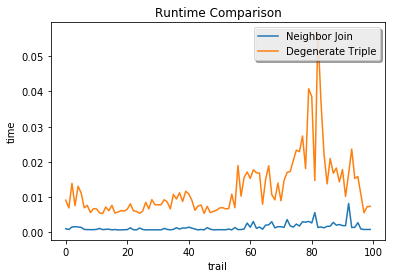

In [138]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(100)
l1, = ax.plot(x, nj_runtimes)
l2, = ax.plot(x, dt_runtimes)

ax.legend((l1, l2), ('Neighbor Join', 'Degenerate Triple'), loc='upper right', shadow=True)

#plt.plot(nj_runtimes)
#plt.plot(dt_runtimes)

ax.set_xlabel('trail')
ax.set_ylabel('time')
ax.set_title('Runtime Comparison')

plt.show()

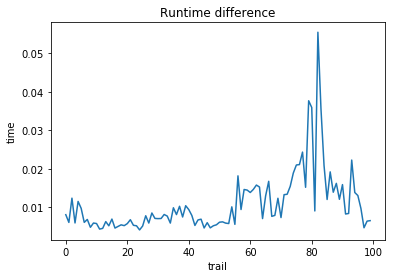

In [139]:
fig, ax = plt.subplots()
x = np.arange(100)
y = [i - j for i,j in zip(dt_runtimes, nj_runtimes)]
l1, = ax.plot(x, y)

#plt.plot(nj_runtimes)
#plt.plot(dt_runtimes)

ax.set_xlabel('trail')
ax.set_ylabel('time')
ax.set_title('Runtime difference')

plt.show()